# Formulating a $\chi^2$ gridsearch in python
## (in the context of modeling a light curve)

Let's say you have some data points d, where d$_i$ is the i$^{th}$ data point in the data array.
Associated with this data you have an array of times, an array of errors, $\sigma$ (with $\sigma_i$ being the error associated with the i$^{th}$ data point).

Finally, you have model points, m$_i$, where each i$^{th}$ model point is the model point associated with a data point with the same time. For a light curve, this means your model flux point is representing the flux at the same time as your data point.

Then, the reduced$^*$ $\chi^2$ statistic is defined as the following: $$\frac{1}{N}\sum^{N}_{i=0}\left(\frac{d_i-m_i}{\sigma_i}\right)^2$$

$^*$The term *reduced* refers to dividing the summation by N, which is the number of data points you are modeling.

This statistic has a more theoretical derivation related to something called a maximum likelihood and a gaussian distribution, but for our purposes it can be thought of as a measure of how well the "model" fits the "data", where a good fit is the associated with the lowest $\chi^2$ (thought hopefully not lower than 1, as this indicates our error bars are wrong).

## Relating this to BATMAN

Based on the equation above, what you end up with is a *single* $\chi^2$ value for each set of data that you compare to a model. In other words, performing a $\chi^2$ test of how *one* model fits your data will return *one* value.

So we need to develop an efficient way to generate many (hundreds or even thousands) of models and calculate the corresponding $\chi^2$ values associated with those models. This then allows us to look at all the generated $\chi^2$ values, find the smallest one, and plot the associated model with our data, thereby finding the *best-fit* model to our data.

There is an intricacy to our BATMAN modeling here that might be confusing at first: we need to keep two time arrays separate. We need a "high resolution" time array that will be used for plotting the actual BATMAN model line. We need this array separate from the data's time array because the data's time array might not necessarily be in order or may be missing segments, leading the BATMAN model to look strange. So that array will be used whenever the BATMAN model is *plotted*.

The other time array is the one associated with your data. THIS time array will be used for the data, *and* for BATMAN *when you are calculating $\chi^2$.* The reason for this is that when you calculate $\chi^2$, you need the data and the model to be the points associated with the same moment in time. In order to do that, you have to be calculating a BATMAN model using the data's time array. I hope that makes sense.

## Doing this in Python

Okay so now we need to figure out how this actually looks in code. I will write a pseudo-example below:

In [28]:
import numpy as np
import matplotlib.pyplot as plt

times = np.random.rand(500,)
data = np.random.normal(3,1,500) + 3*times #This generates 1000 random data points
error = np.linspace(0.5,0.5,500) #I'm defining my errors to be a fixed value

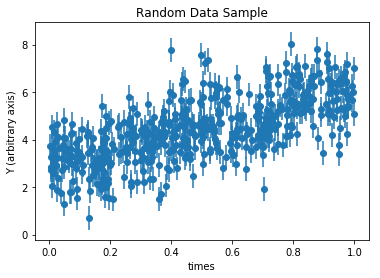

In [29]:
plt.figure()
plt.errorbar(times, data,yerr=error,fmt='o')
plt.title('Random Data Sample')
plt.xlabel('times')
plt.ylabel('Y (arbitrary axis)')
plt.show()

Above is a "data set" that I created by generating a bunch of randomly distributed points with some slope.

We have the data and errors, and now we need to define a model. I am going to assume this model follows a linear trend, and that it can be fit as a line (y = mx +b). However, I don't just want to choose arbitrary values of m and b and hope it all makes sense, I want to loop through a bunch of different possible values and find the "best-fit" model parameters.

In [37]:
def linear_fit(x,y,m,b): #Defining the model function. For you, the model function is BATMAN
    y = m*x + b
    return y
    
m = np.linspace(0,10,30) #arrays of parameters I want to analyze to find the best fit
b = np.linspace(-1,10,30)

chisq = np.zeros(shape=(len(data),len(m),len(b)))

for k in range(len(b)):
    for j in range(len(m)):
        
        model = linear_fit(times,data,m[j],b[k]) #inputting all x and y values but a single value for m and b
        
        for i in range(len(data)):
            chisq[i,j,k] = ((data[i]-model[i])/error[i])**2.0

            
chi2sum = np.sum(chisq, axis = 0) #This sums up the chi2 values along a certain axis of the array
chi2_min = np.amin(chi2sum)
indices = np.where(chi2sum == chi2_min) #This finds the location where the minimum chi2 is

print("Minimum Reduced Chi2:",chi2_min/len(data))
Best_m = m[indices[0]]
print("Best-fit slope (m):",Best_m)
Best_b = b[indices[1]]
print("Best-fit offset (b):",Best_b)

Minimum Reduced Chi2: 3.9618032748407686
Best-fit slope (m): [3.44827586]
Best-fit offset (b): [2.79310345]


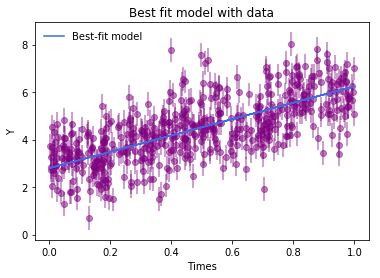

In [39]:
best_model = linear_fit(times,data,Best_m,Best_b) #this creates the best fit model using best fit parameters

plt.figure()
plt.plot(times,best_model,zorder=100,label='Best-fit model',color='royalblue')
plt.errorbar(times,data,yerr=error,fmt='o',alpha=0.5,color='purple')
plt.ylabel('Y')
plt.xlabel('Times')
plt.title('Best fit model with data')
plt.legend(frameon=False)
plt.show()